## Exercise 6: Mesoscopic Structures


Today we are going to continue our analysis on the mesoscopic structure of the Karate club network.

In [2]:
import numpy as np
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
import random

%matplotlib inline

In [3]:
K = nx.karate_club_graph()
print(nx.info(K))

Name: Zachary's Karate Club
Type: Graph
Number of nodes: 34
Number of edges: 78
Average degree:   4.5882


### Task 1: Finding Communities with the Louvain algorithm

Compare the modularity of the best Girvan-Newman partition with the Louvain partition that was obtained in the previous exericse. Since `networkx` does not implement the Louvain algorithm, you have to install a different package for that purpose:
Open your command line, activate conda and ```pip install python-louvain```. 
Note that this Louvain library has some slightly different syntax, and is imported as ```community```.

Plot the partitions of the two algorithms side by side.

In [4]:
# make sure that python-louvain has been installed
import community as louvain

In [5]:
# feel free to check the documentation here
# ?louvain.best_partition

In [6]:
louvain_part = louvain.best_partition(K)
louvain_mod = louvain.modularity(louvain_part, K)
louvain_mod

0.4188034188034188

### Task 2: Random Walks and Communities

#### a) Implementing Random Walks

Write a function that simulates a random walk of $k$ steps on a network given network. It should first place a random walker at a random node in the network, then take $k$ steps along the edges of the graph, recording the nodes that the walker visits in a list. It should return that list.

In [7]:
def random_walk(G,k):
    """
    :param G: networkx graph
    :param k: number of random walk steps to conduct
    :
    :return:  a list of the IDs of the nodes that were visited
    """
        
    current_position = random.choice(list(G.nodes()))
    nodes_visited = [current_position]
    for _ in range(k):
        neighbors =list(G[current_position])
        current_position = random.choice(neighbors)
        nodes_visited.append(current_position)
    return nodes_visited

In [8]:
random_walk(K,5)

[6, 4, 6, 5, 6, 0]

#### b) A Simple Random Walk
Conduct a random Walk of 15 steps on the karate club network. 
Plot the network with the nodes visited in that colored in a different color from the rest of the nodes.

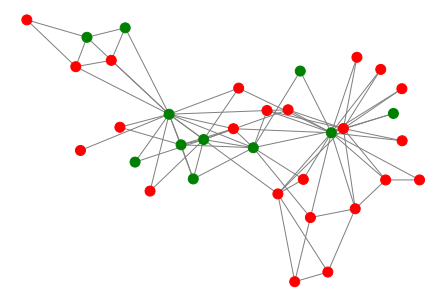

In [9]:
walk = list(set(random_walk(K,15)))
color_map = []

for node in K:
    if node in walk:
        color_map.append('green')
    else:
        color_map.append('red')

    
nx.draw_spring(K, node_color=color_map, node_size=100, edge_color='grey')

#### c) Monitoring In-Community Walks

Let a random walker run for 500 steps over the karate club graph. Map the resulting sequence of nodes to a sequence of 1's and 0's: 1 if the node visited is in the "Mr. Hi" group and 0 if the node visited is in the "Officer" group. 
Plot the sequence of ones and zeroes, and calculate how long the walker typically stays within a group. Plot these lengths as a histogram.

In [10]:
true_partition = nx.get_node_attributes(K,'club')

binary_sequence = []
for visited_node in random_walk(K,500):
    if true_partition[visited_node] =='Mr. Hi':
        binary_sequence.append(1)
    else:
        binary_sequence.append(0)

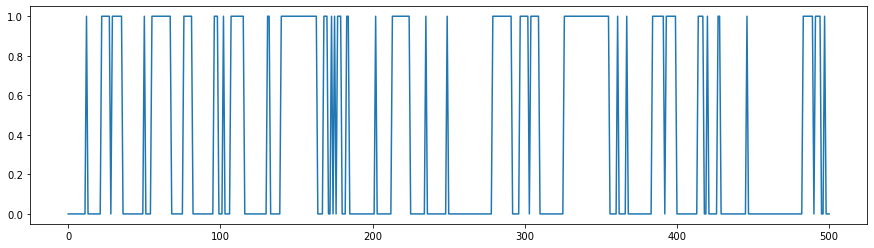

In [11]:
plt.figure(figsize=(15,4))
plt.plot(binary_sequence)

(array([35., 12.,  6.,  8.,  5.,  0.,  1.,  0.,  2.,  1.]),
 array([ 0. ,  3.5,  7. , 10.5, 14. , 17.5, 21. , 24.5, 28. , 31.5, 35. ]),
 <BarContainer object of 10 artists>)

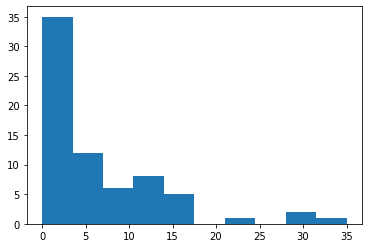

In [12]:
previous = binary_sequence[0]
within_group_walk_lengths = []
length= 0

for group in binary_sequence[1:]:
    if group == previous:
        length+=1
    else:
        within_group_walk_lengths.append(length)
        length = 0
        previous = group

plt.hist(within_group_walk_lengths)

#### d) Extending the Random Walk

Now let the walker take 10,000 steps and again plot how long the walker stays in a group. You can use a log-log scale!

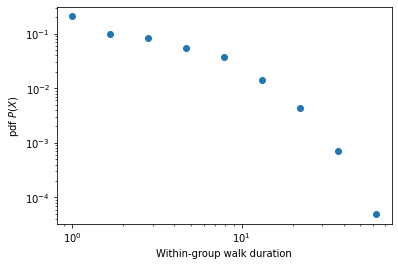

In [13]:
true_partition = nx.get_node_attributes(K,'club')

binary_sequence = []
for visited_node in random_walk(K,100000):
    if true_partition[visited_node] =='Mr. Hi':
        binary_sequence.append(1)
    else:
        binary_sequence.append(0)
        
previous = binary_sequence[0]
within_group_walk_lengths = []
length= 0

for group in binary_sequence[1:]:
    if group == previous:
        length+=1
    else:
        within_group_walk_lengths.append(length)
        length = 0
        previous = group

bin_edges = np.logspace(np.log10(1), np.log10(max(within_group_walk_lengths)), num=10)
density, _ = np.histogram(within_group_walk_lengths, bins=bin_edges, density=True)
fig02 = plt.figure()
plt.loglog(bin_edges[:-1], density, marker='o', linestyle='none')

plt.xlabel("Within-group walk duration")
plt.ylabel(r"pdf $P(X)$")
plt.show()

### Task 3: Comparing Communities in Random and Empirical Graphs

#### a) Communities in Random Graphs

Generate 100 Erdos-Renyi graphs with 250 nodes and average degree 5. Detect their communities using the Louvain method, and store the modularities of the resulting partitions. Plot the resulting distribution of modularities as a histogram. What do you observe?  

(0.0, 1.0)

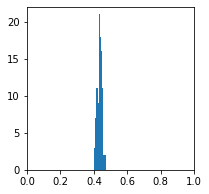

In [24]:
list_of_er_modularities = []
for _ in range(100):
    G = nx.erdos_renyi_graph(250,5/(250-1))
    er_louvain_partition =louvain.best_partition(G)
    list_of_er_modularities.append(louvain.modularity(er_louvain_partition,G))
plt.figure(figsize=(3,3))
plt.hist(list_of_er_modularities)
plt.xlim([0,1])

**Answer:** The Louvain method finds non-zero modularity partitions of random networks very consistently! This means we should always compare the modularity of partitions of real networks with similar random ones...

#### b)  Comparing the Karate Club's Modularity With a Similar Random Network

Load the Karate club graph and create 200 Erdos Renyi graphs with the same number of nodes and average degree as the Karate Club graph. Calculate their modularities under a Louvain partition. Then calculate the modularity of the Louvain partition of the real Karate club network. Plot the distribution of Erdos Renyi modularities as a histogram and indicate with a vertical red line the true network's Louvain modularity.

In [25]:
#first find the parameters for the ER networks...
kc_avg_degree= np.mean([x[1] for x in K.degree()])
kc_n_nodes = len(K.nodes())
er_p = kc_avg_degree/(kc_n_nodes-1)
print(er_p)

0.13903743315508021


In [26]:
list_of_er_modularities = []

for _ in range(200):
    G = nx.erdos_renyi_graph(kc_n_nodes,er_p)
    er_louvain_partition =louvain.best_partition(G)
    list_of_er_modularities.append(louvain.modularity(er_louvain_partition,G))

kc_mod = louvain.modularity(louvain.best_partition(K),K)    

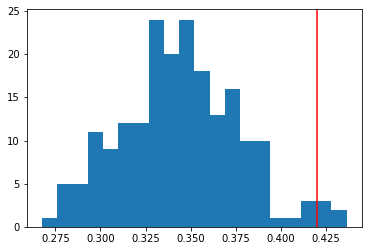

In [27]:
plt.hist(list_of_er_modularities,bins= 20)
plt.axvline(kc_mod,color='red')

#### c) Comparing Karate Club's Modularity With Configuration Models
Repeat the process from b) with 200 configuration models that have the same degree distribution as the karate club graph!

In [28]:
list_of_cm_modularities = []

for _ in range(200):
    G = nx.configuration_model([x[1] for x in K.degree()])
    er_louvain_partition =louvain.best_partition(G)
    list_of_cm_modularities.append(louvain.modularity(er_louvain_partition,G))


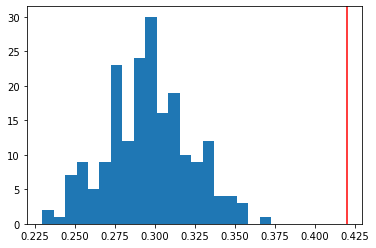

In [29]:
plt.hist(list_of_cm_modularities,bins= 20)
plt.axvline(kc_mod,color='red')

### Task 4: Assortativity of the Karate Club Graph

#### a) The Degree Correlation Function

Write a function that computes the values of degree correlation function $k_{nn}(k)$ for any input graph. Use the signature specified on the cell below!

In [30]:
def knn(G):
    """
    :param G: networkx graph
    :
    :return:  a dictionary where the keys are the node degrees occurring in the graph, 
    :         and the values correspond to the average correlation $k_nn(k)$!
    """
    
    knn_ki = nx.average_neighbor_degree(G)
    dd = dict()
    knn = dict()
    
    for v in G.nodes():
        k = G.degree(v)
        
        if k in dd:
            dd[k] += 1
            knn[k] += knn_ki[v]
        else:
            dd[k] = 1
            knn[k] = knn_ki[v]
    
    for k in dd:
        knn[k] = knn[k]/dd[k]
        
    return knn

#### b) Assortativity of the Karate Club Graph

Compute the degree assortativity coefficient of the karate club graph, and use your implementation from a) to plot each degree $k$ against $k_{nn}(k)$. Do you think this network is assortative or disassortative? Justify your answer!

In [31]:
r = nx.degree_assortativity_coefficient(K)
print(r)

-0.47561309768461457


In [32]:
rd = knn(K)

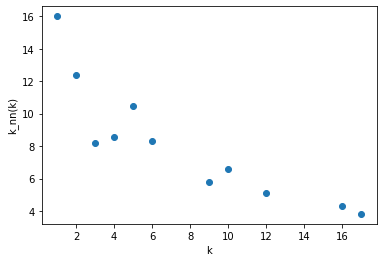

In [33]:
plt.scatter(rd.keys(), rd.values())

plt.xlabel("k")
plt.ylabel("k_nn(k)")
plt.show()

__Answer:__ The network displays a clear disassortativity, with the assortativity coefficient being much smaller than zero, and also decreasing values of $k_{nn}(k)$ with increasing $k$.